In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.utils import resample

# Load the Wisconsin Breast Cancer dataset
file_path = r"C:\Users\Shaurya\Downloads\data.csv"
df = pd.read_csv(file_path)

# Drop unnecessary columns
df = df.drop(columns=['id', 'Unnamed: 32'])

# Encode the 'diagnosis' column (M=1, B=0)
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df['diagnosis'] = label_encoder.fit_transform(df['diagnosis'])

# Handle missing values by dropping rows with null values
df = df.dropna()

# Separate majority and minority classes
majority_class = df[df['diagnosis'] == 0]
minority_class = df[df['diagnosis'] == 1]

# Upsample minority class to balance the dataset
minority_upsampled = resample(minority_class,
                              replace=True,     # sample with replacement
                              n_samples=len(majority_class),    # to match majority class
                              random_state=42) # reproducible results

# Combine majority class with upsampled minority class
balanced_df = pd.concat([majority_class, minority_upsampled])

# Split the balanced dataset into features (X) and target variable (y)
X = balanced_df.drop(columns=['diagnosis'])
y = balanced_df['diagnosis']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply PCA
pca = PCA(n_components=10)  # You can adjust the number of components
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Train KNN model
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train_pca, y_train)

# Make predictions
y_pred = knn_model.predict(X_test_pca)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:\n", report)


Accuracy: 0.9580
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.98      0.96        81
           1       0.97      0.94      0.95        62

    accuracy                           0.96       143
   macro avg       0.96      0.96      0.96       143
weighted avg       0.96      0.96      0.96       143



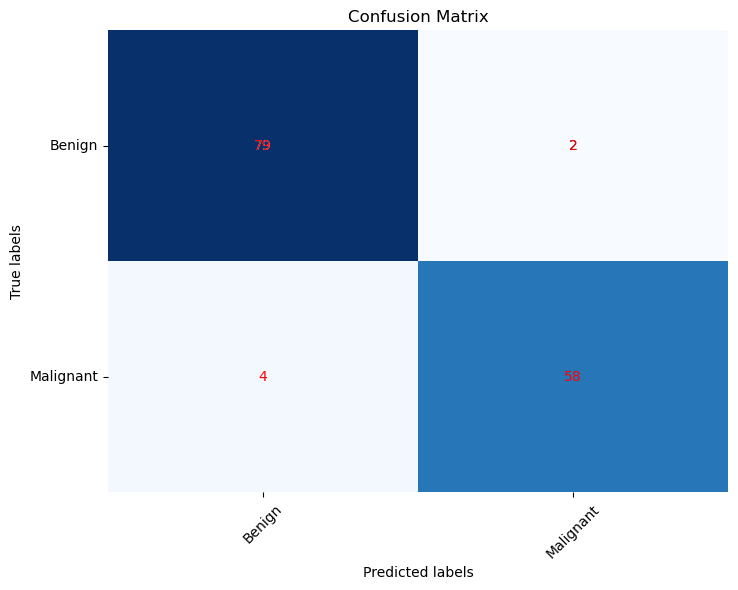

In [3]:
#confusion matrix
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.xticks(rotation=45)
plt.yticks(rotation=0)

# Add counts
for i in range(len(conf_matrix)):
    for j in range(len(conf_matrix[i])):
        plt.text(j + 0.5, i + 0.5, str(conf_matrix[i][j]), ha='center', va='center', color='red')

plt.show()


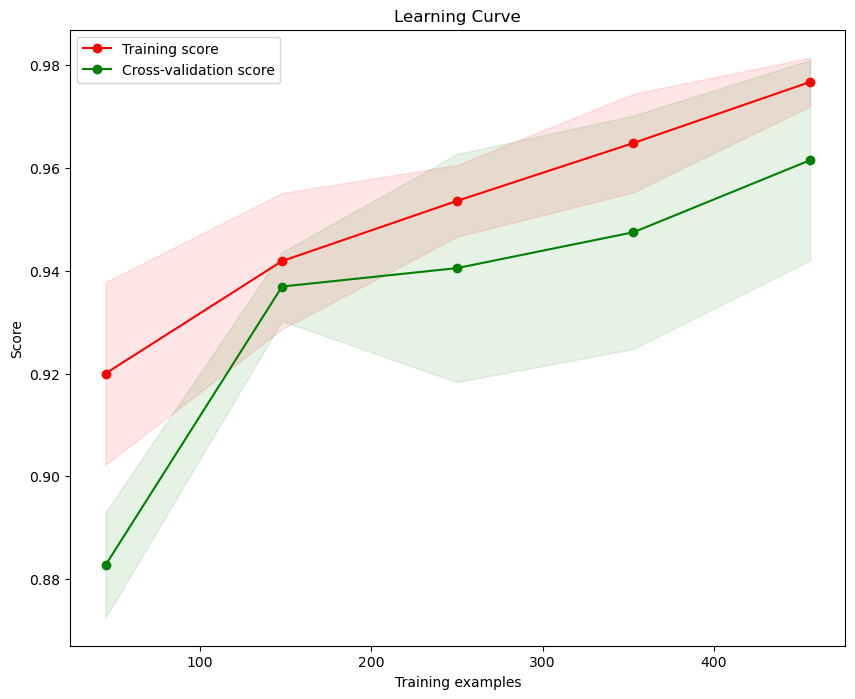

In [4]:
#learning curve
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(knn_model, X_train_pca, y_train, cv=5)

plt.figure(figsize=(10, 8))
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Cross-validation score")

plt.xlabel("Training examples")
plt.ylabel("Score")
plt.title("Learning Curve")
plt.legend(loc="best")
plt.show()


C:\Users\Shaurya\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Shaurya\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


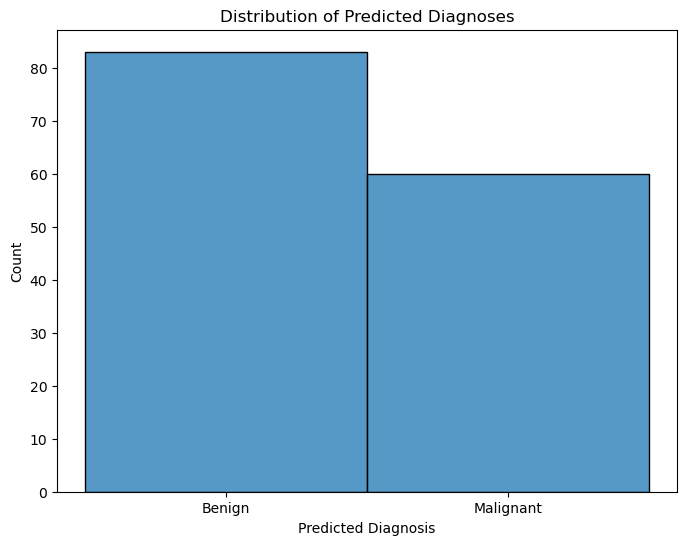

In [6]:
# Distribution of Predictions
plt.figure(figsize=(8, 6))
sns.histplot(y_pred, kde=False, bins=2)
plt.xlabel('Predicted Diagnosis')
plt.ylabel('Count')
plt.title('Distribution of Predicted Diagnoses')
plt.xticks(ticks=[0.25, 0.75], labels=['Benign', 'Malignant'])
plt.show()


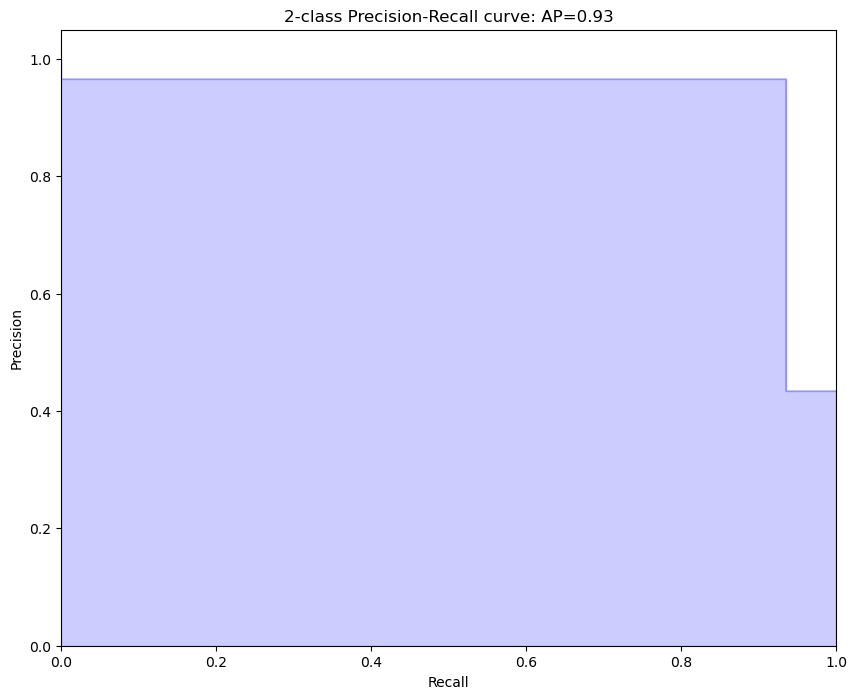

In [7]:
# Precision-Recall Curve
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, _ = precision_recall_curve(y_test, y_pred)
average_precision = average_precision_score(y_test, y_pred)

plt.figure(figsize=(10, 8))
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
plt.show()

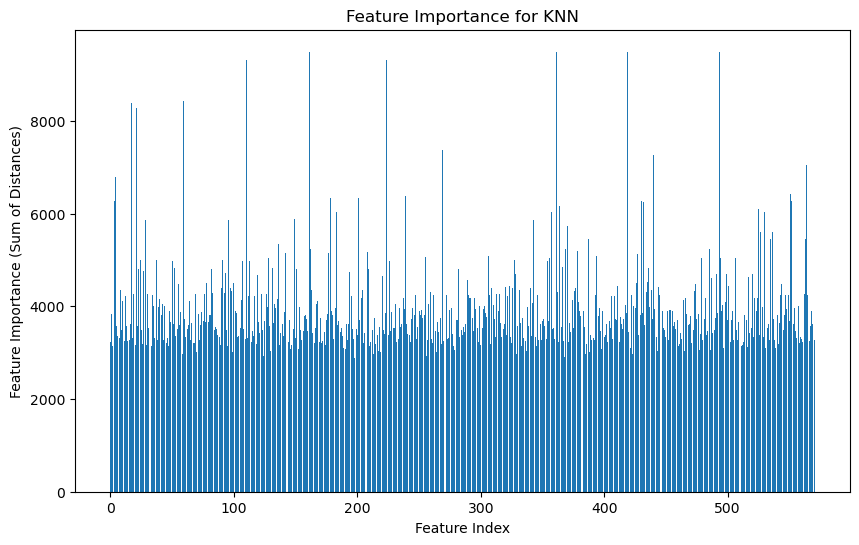

In [8]:
# Calculate distances between points in the feature space
from sklearn.metrics.pairwise import euclidean_distances

# Calculate pairwise Euclidean distances between points
distances = euclidean_distances(X_train_pca)

# Summarize distances for each feature
feature_importance = np.sum(distances, axis=0)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_importance)), feature_importance)
plt.xlabel('Feature Index')
plt.ylabel('Feature Importance (Sum of Distances)')
plt.title('Feature Importance for KNN')
plt.show()
